In [1]:
!pip install arch yfinance

# Install Condacolab to integrate Conda with Colab
!pip install -q condacolab

# Import and run Condacolab to enable Conda
import condacolab
condacolab.install()

# Install pmdarima from conda-forge using Conda
!conda install -c conda-forge pmdarima -y

import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from pmdarima.arima import auto_arima
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

from sktime.transformations.series.boxcox import LogTransformer

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# Primera descripción de los datos

### Importamos los datos, presentamos las primeras y últimas filas

In [2]:
aapl_df = pd.read_csv('aapl.csv',sep=';')

aapl_df.head()

,Trimeste,fecha,Ingresos
0,Q1 1990,12/29/1989,"1493,4"
1,Q2 1990,03/30/1990,"1346,2"
2,Q3 1990,06/29/1990,"1364,8"
3,Q4 1990,09/28/1990,"1354,1"
4,Q1 1991,12/28/1990,"1675,5"


In [3]:
aapl_df.tail()

,Trimeste,fecha,Ingresos
122,Q3 2020,06/27/2020,59685
123,Q4 2020,09/26/2020,64698
124,Q1 2021,12/26/2020,111439
125,Q2 2021,03/27/2021,89584
126,Q3 2021,06/26/2021,81434


#### Se trata del revenue trimetral de Apple desde 1990 hasta 2021

##### Modificamos el formato de las fechas y las colocamos como indice del dataframe

In [4]:
aapl_df['fecha'] = pd.to_datetime(aapl_df['fecha'],format="%m/%d/%Y")
aapl_df.sort_values(by='fecha', inplace=True)
aapl_df = aapl_df.set_index('fecha')
aapl_df.tail()

,Trimeste,Ingresos
fecha,,
2020-06-27,Q3 2020,59685
2020-09-26,Q4 2020,64698
2020-12-26,Q1 2021,111439
2021-03-27,Q2 2021,89584
2021-06-26,Q3 2021,81434


#### Verificamos que el dataframe se encuentre completo

In [5]:
aapl_df.isnull().sum()

,0
Trimeste,0
Ingresos,0


##### Revisamos que los datos sean numéricos para la columna 'Ingresos'

In [6]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 1989-12-29 to 2021-06-26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Trimeste  127 non-null    object
 1   Ingresos  127 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB


In [7]:
aapl_df.Ingresos = aapl_df.Ingresos.str.replace(',', '.').astype(float)
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 1989-12-29 to 2021-06-26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Trimeste  127 non-null    object 
 1   Ingresos  127 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [8]:
aapl_df.tail()

,Trimeste,Ingresos
fecha,,
2020-06-27,Q3 2020,59685.0
2020-09-26,Q4 2020,64698.0
2020-12-26,Q1 2021,111439.0
2021-03-27,Q2 2021,89584.0
2021-06-26,Q3 2021,81434.0


##### Nos aseguramos que la información sea consistente en todo el dataframe, es decir, que en todo momento trabajemos con trimestres

In [9]:
aapl_df_res = aapl_df.resample("Q").last()
aapl_ingresos = aapl_df_res["Ingresos"]
aapl_ingresos.tail()

,Ingresos
fecha,
2020-06-30,59685.0
2020-09-30,64698.0
2020-12-31,111439.0
2021-03-31,89584.0
2021-06-30,81434.0


### Grafico la evolución de los ingresos en el tiempo

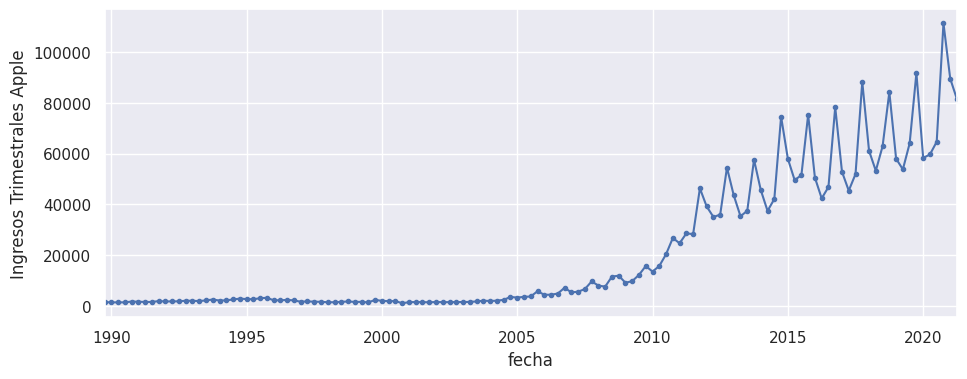

In [10]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = aapl_ingresos.plot(marker='.', linestyle='-')
ax.set_ylabel('Ingresos Trimestrales Apple')
plt.show()

* ¿Es estacionaria en media o varianza?

#### Para tener una mejor visualización de los componentes de la serie, el siguiente paso será aplicar una descomposición

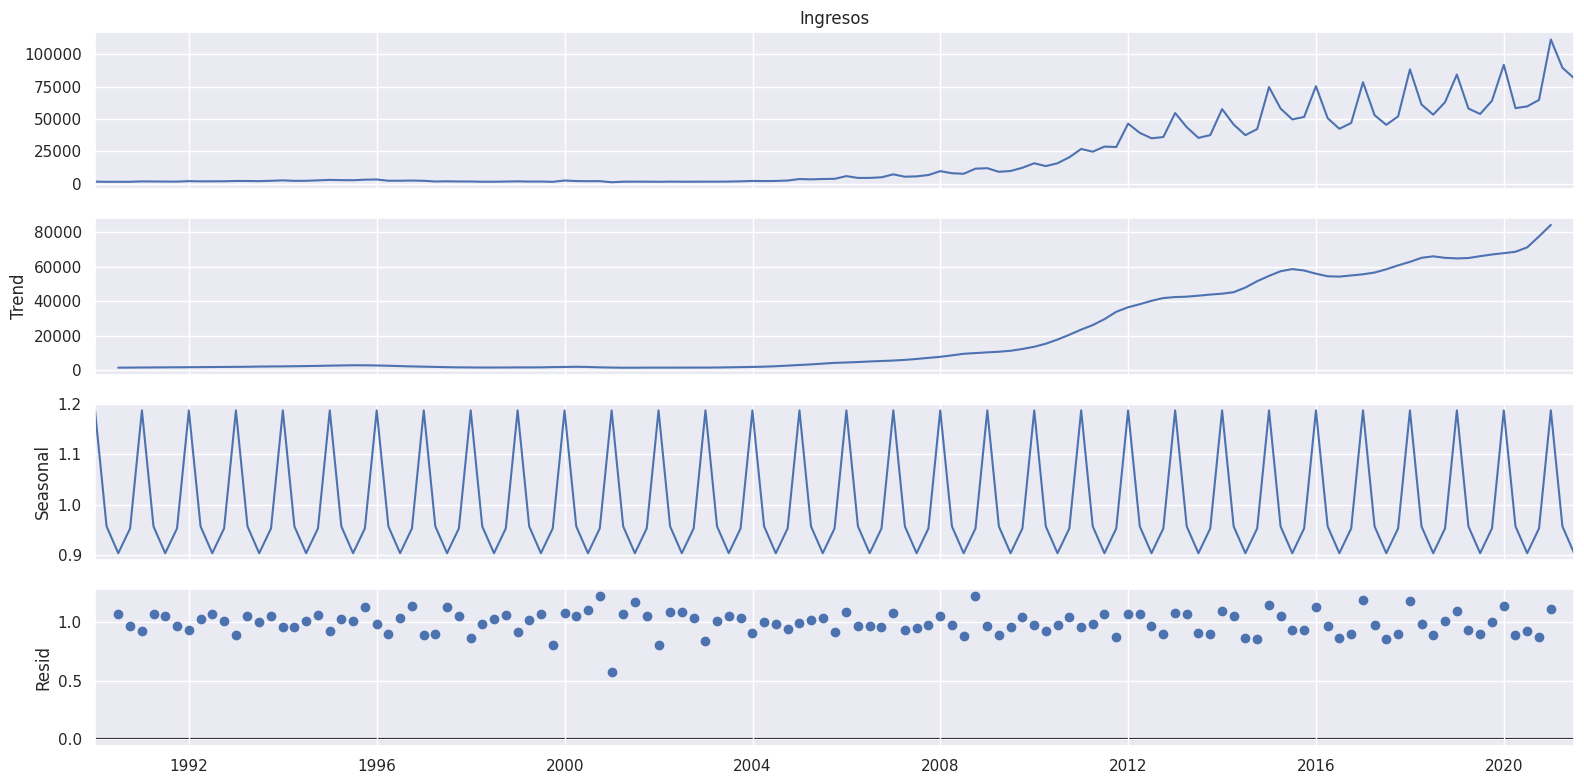

In [11]:
sns.set(rc={'figure.figsize':(16, 8)})
seasonal_decompose(aapl_ingresos, model='multiplicative', period=4).plot()
plt.show()

* Aquí se puede notar de una manera más simple

### Analizamos particularmente el componente estacional de la serie

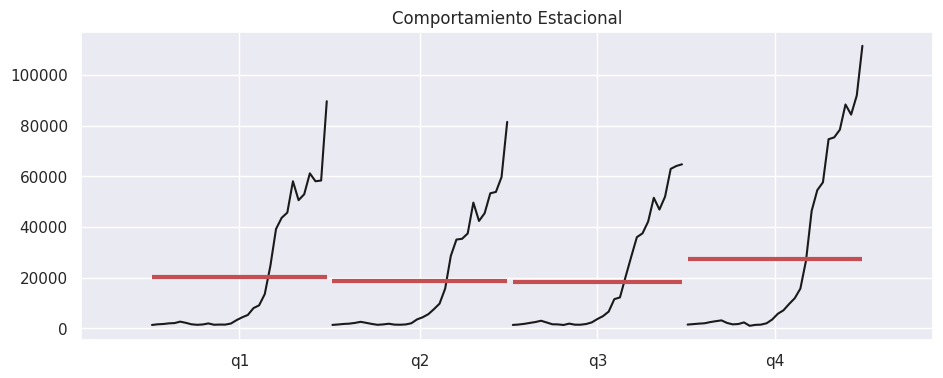

<Figure size 1100x400 with 0 Axes>

In [12]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = plt.gca()
sm.graphics.tsa.quarter_plot(aapl_ingresos,ax=ax)
ax.set_title('Comportamiento Estacional')
plt.show()

plt.savefig('output.png')

* Si uno conoce el negocio de Apple, notará que este comportamiento tiene total sentido, dado que la presentación de los nuevos modelos año a año se realizan en septiembre y las primeras ventas de los productos se dan en el ultimo tramo del año

### El Componente estacional no es estacionario, al igual que en media o en varianza.

### Es necesario averiguar las ventas anuales de Apple

* Para ello debemos realizar un cambio en el dataframe


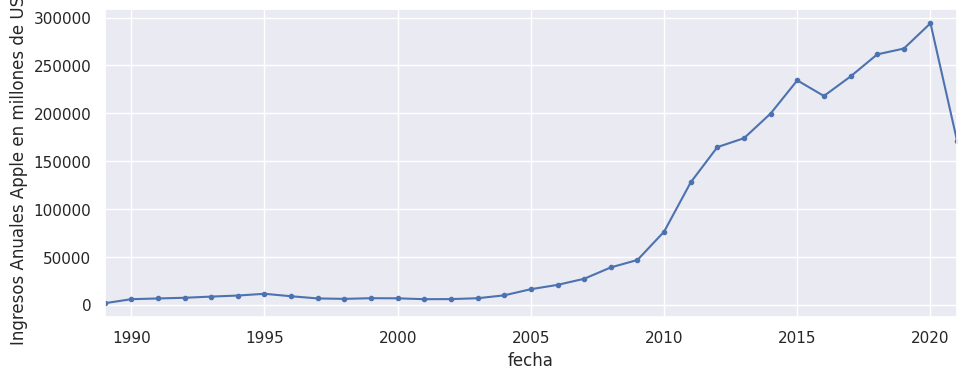

In [13]:
aapl_anual = aapl_ingresos.resample('Y').sum()
ax = aapl_anual.plot(marker='.', linestyle='-')
ax.set_ylabel('Ingresos Anuales Apple en millones de USD')
plt.show()

##### ¡ Atención !

#### Debemos tener en cuenta que solo contamos con dos trimestres para el año 2021, con lo cual, la caida observada en el grafico anterior no es representativa con la realidad.

### Analizaré los crecimientos anuales de los ingresos

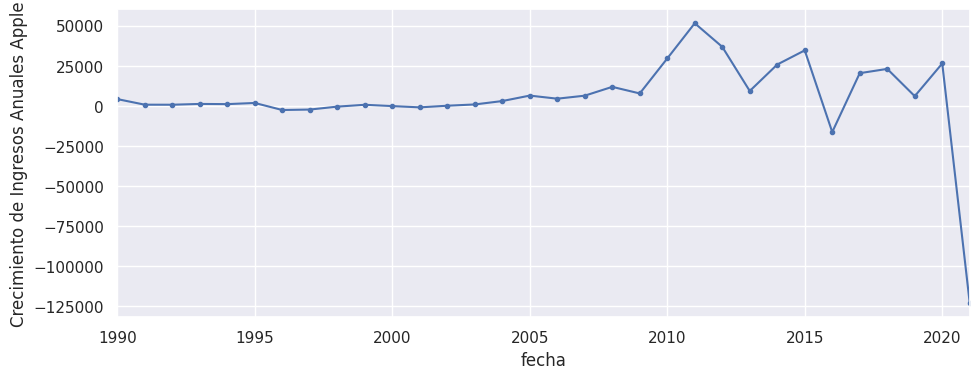

In [14]:
aapl_anual_crec = aapl_anual.diff()
aapl_anual_crec.dropna(inplace=True)
ax = aapl_anual_crec.plot(marker='.', linestyle='-')
ax.set_ylabel('Crecimiento de Ingresos Anuales Apple')
plt.show()

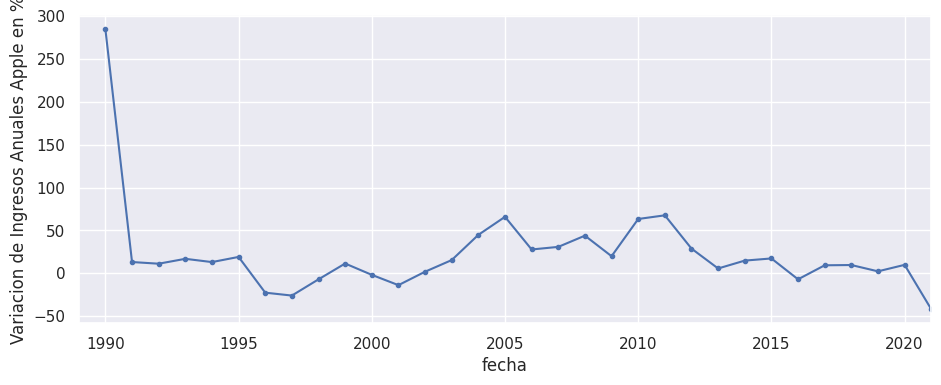

In [15]:
ax = aapl_anual.pct_change().mul(100).plot(marker='.', linestyle='-')
ax.set_ylabel('Variacion de Ingresos Anuales Apple en %')
plt.show()

##### ¡ Atención 2 !

#### Tenemos el mismo caso que el presentado anteriormente. Debemos tener en cuenta que solo contamos con dos trimestres para el año 2021, con lo cual, la caida observada en el grafico anterior no es representativa con la realidad.

## Estimación mediante ETS

* En primer lugar seleccionamos nuestros datos de entrenamiento y test, en este caso contamos con 8 períodos para el test y el resto para la etapa de train

Cantidad de períodos en Train: 119
Cantidad de períodos en Test: 8


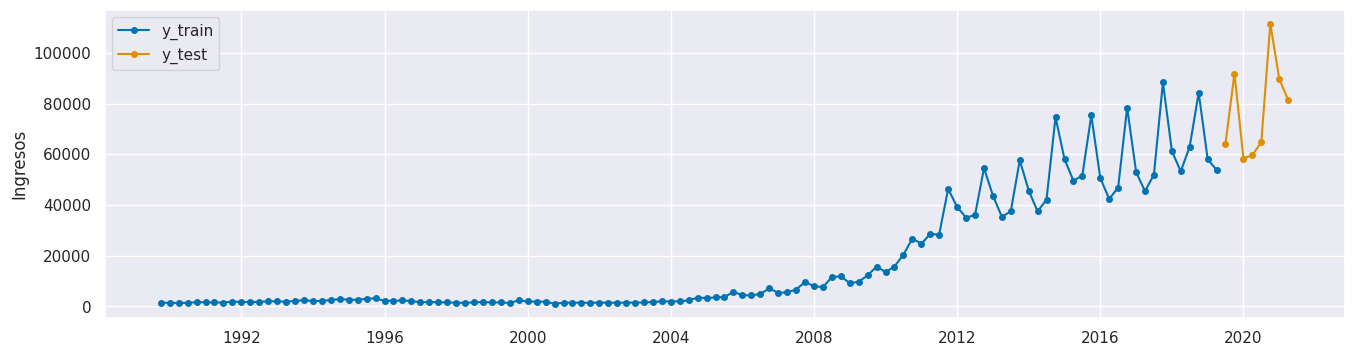

In [16]:
y_train, y_test = temporal_train_test_split(y =aapl_ingresos.astype('float64').to_period('Q').sort_index(), test_size=8)

# Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [17]:
y_test

,Ingresos
2019Q3,64040.0
2019Q4,91819.0
2020Q1,58313.0
2020Q2,59685.0
2020Q3,64698.0
2020Q4,111439.0
2021Q1,89584.0
2021Q2,81434.0


#### Es necesario resaltar que para este caso, dejamos fuera del entrenamiento del modelo al COVID para poder cuantificar su efecto en los ingresos

In [18]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
aapl_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

In [19]:
aapl_auto_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [20]:
aapl_auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Fri, 21 Mar 2025   AIC                           1956.050
Time:                        13:33:04   BIC                           1983.841
Sample:                    12-31-1989   HQIC                          1967.335
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal     0.3568      0.077      4.646      0.000       0.206       0.507
initial_level       1370.9326    598.927      2.289      0.022     197.057    2544.808
initial_trend         46.0330     96.115      0.479      0.632    -142.349     234.415
initial_seasonal.0     0.8649      0.393      2.199      0.028       0.094       1.636
initial_seasonal.1     0.8891      0.402      2.210      0.027       0.101       1.678
initial_seasonal.2     0.9181      0.414      2.216      0.027       0.106       1.730
initial_seasonal.3     1.0000      0.441      2.265      0.024       0.135       1.865
===================================================================================
Ljung-Box (Q):                        5.15   Jarque-Bera (JB):               112.84
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.39
Prob(H) (two-sided):                  0.57   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

 #### Realizamos la predicción para los 8 periodos de test

In [21]:
#step 5: querying predictions
aapl_pred = aapl_auto_model.predict(fh=list(fh))
aapl_pred

,Ingresos
2019Q3,58581.330174
2019Q4,85963.048914
2020Q1,59751.805481
2020Q2,53079.532246
2020Q3,58323.475347
2020Q4,85584.252363
2021Q1,59488.218515
2021Q2,52845.120587


#### Graficamos las series para tener una imagen de comparación entre los valores reales vs los predichos

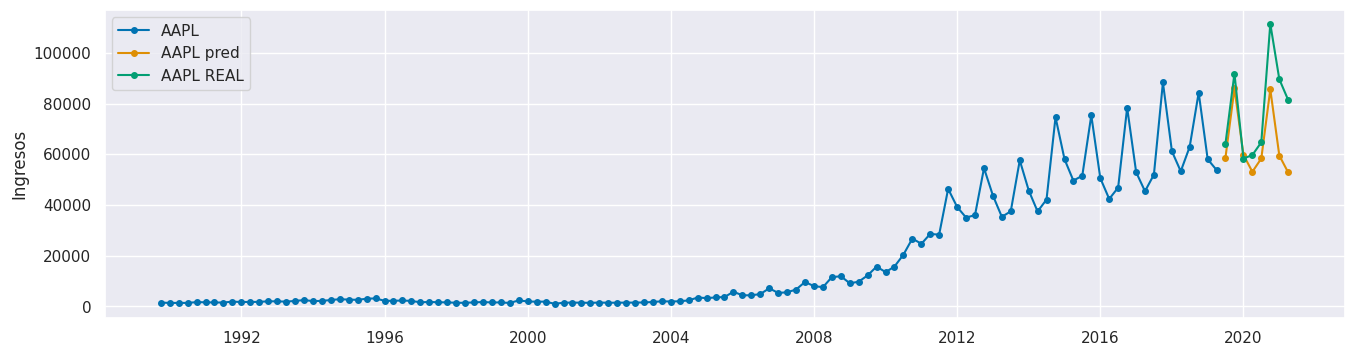

In [22]:
plot_series(y_train, aapl_pred, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])
plt.show()

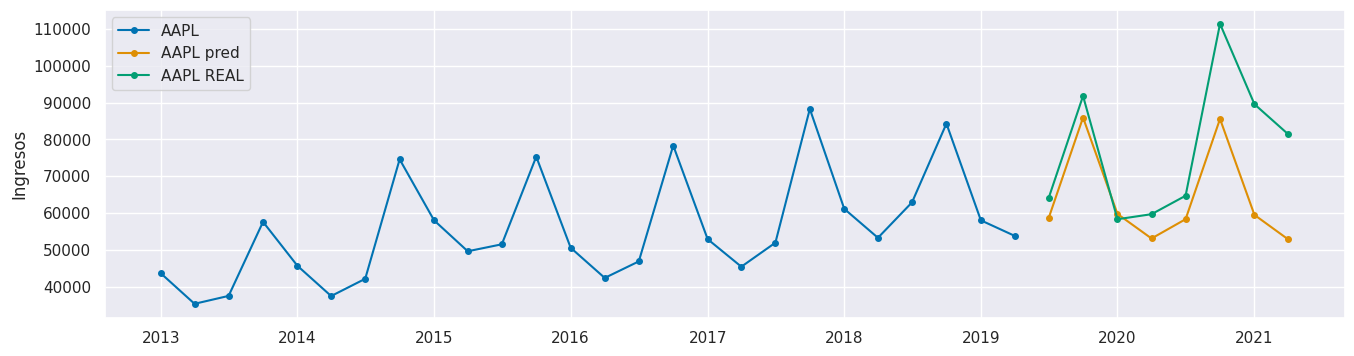

In [23]:
plot_series(y_train["2013":], aapl_pred, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])
plt.show()

#### Calculamos 2 métricas de error para comparar con otros modelos

In [24]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, aapl_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 17825.45


In [25]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, aapl_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 16.27%


# Estimación mediante metodología ARIMA

### Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

#### Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaré logaritmo y luego graficaré para evidenciar si se ha logrado el objetivo

In [26]:
transformer = LogTransformer()
log_aapl_ts= transformer.fit_transform(aapl_ingresos)
log_aapl_ts.tail()

,Ingresos
fecha,
2020-06-30,10.996836
2020-09-30,11.077486
2020-12-31,11.621233
2021-03-31,11.402932
2021-06-30,11.307548


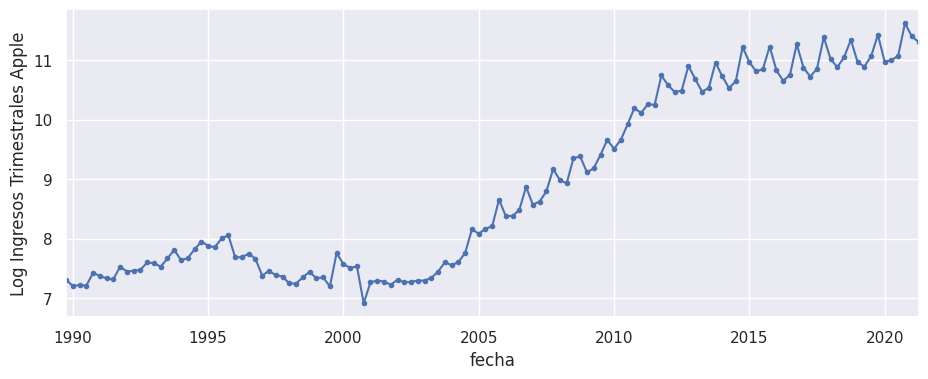

In [27]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = log_aapl_ts.plot(marker='.', linestyle='-')
ax.set_ylabel('Log Ingresos Trimestrales Apple')
plt.show()

Separo en entrenamiento y test a la serie transformada

119 8


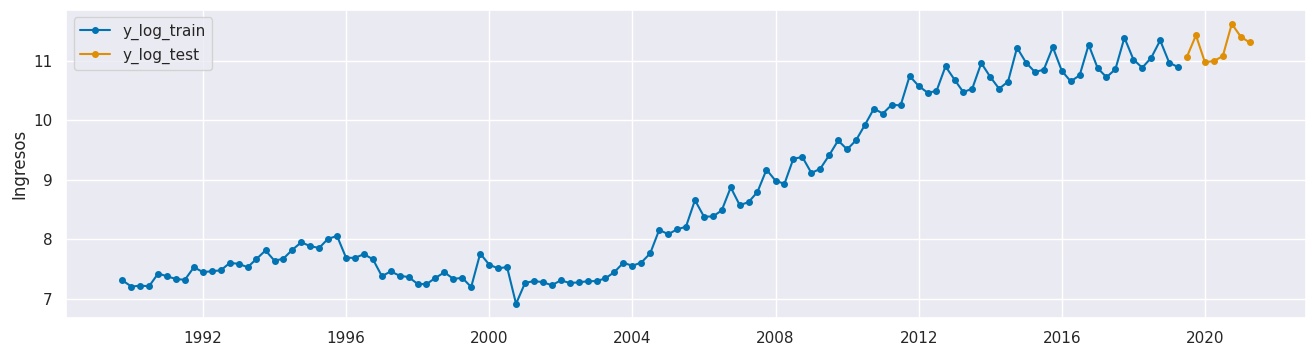

In [28]:
y_log_train, y_log_test = temporal_train_test_split(y = log_aapl_ts.astype('float64').to_period('Q'), test_size=8)

plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Genero el modelo y se entrena con los datos de train

In [29]:
fh = np.arange(1, y_log_test.shape[0]+1)
from pmdarima import auto_arima
aapl_auto_model = auto_arima(y_log_train, sp=4,suppress_warnings=True)

In [30]:
y_log_train

,Ingresos
1989Q4,7.308811
1990Q1,7.205041
1990Q2,7.218763
1990Q3,7.210892
1990Q4,7.423867
...,...
2018Q2,10.883035
2018Q3,11.049301
2018Q4,11.342256
2019Q1,10.968457


In [31]:
aapl_auto_model.fit(y_log_train)

ARIMA(order=(4, 1, 5), scoring_args={}, suppress_warnings=True)

Vemos el resultado

In [32]:
aapl_auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  119
Model:               SARIMAX(4, 1, 5)   Log Likelihood                  61.921
Date:                Fri, 21 Mar 2025   AIC                           -101.842
Time:                        13:33:22   BIC                            -71.364
Sample:                    12-31-1989   HQIC                           -89.467
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0182      0.025      0.742      0.458      -0.030       0.066
ar.L1         -0.1473      0.183     -0.805      0.421      -0.506       0.211
ar.L2         -0.1279      0.179     -0.716      0.474      -0.478       0.222
ar.L3         -0.1344      0.156     -0.862      0.389      -0.440       0.171
ar.L4          0.8288      0.165      5.010      0.000       0.505       1.153
ma.L1         -0.1837      0.213     -0.862      0.389      -0.601       0.234
ma.L2          0.0125      0.218      0.057      0.954      -0.414       0.439
ma.L3          0.2413      0.142      1.693      0.090      -0.038       0.521
ma.L4         -0.5328      0.207     -2.580      0.010      -0.938      -0.128
ma.L5          0.2105      0.145      1.455      0.146      -0.073       0.494
sigma2         0.0198      0.002      9.762      0.000       0.016       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               787.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -1.74
Prob(H) (two-sided):                  0.27   Kurtosis:                        15.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observamos las predicciones

In [33]:
fh = 8

In [34]:
aapl_log_pred = aapl_auto_model.predict(fh)
print(np.exp(aapl_log_pred))

2019Q3    61705.832949
2019Q4    87120.411740
2020Q1    63481.028234
2020Q2    58069.889176
2020Q3    66900.016691
2020Q4    93729.641427
2021Q1    69441.443015
2021Q2    64514.434324
Freq: Q-DEC, dtype: float64


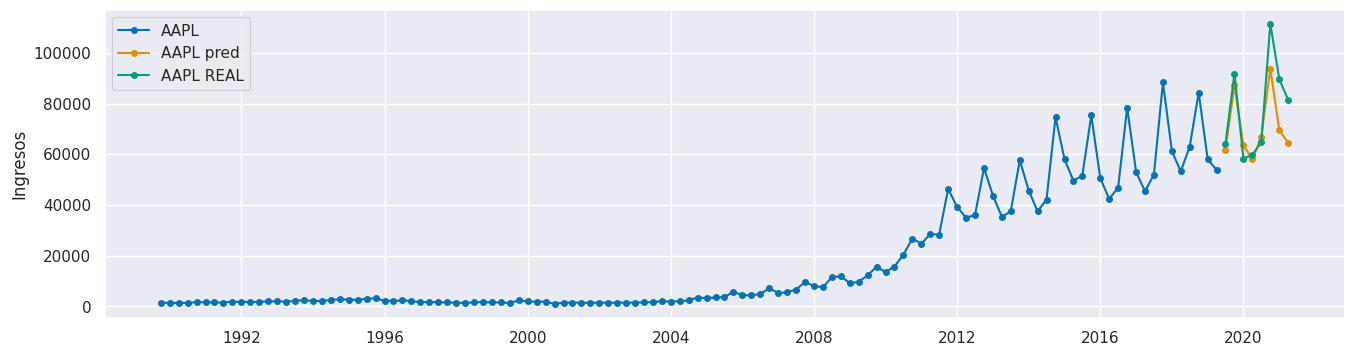

In [35]:
plot_series(np.exp(y_log_train), np.exp(aapl_log_pred), np.exp(y_log_test), labels=["AAPL", "AAPL pred", "AAPL REAL"])
plt.show()

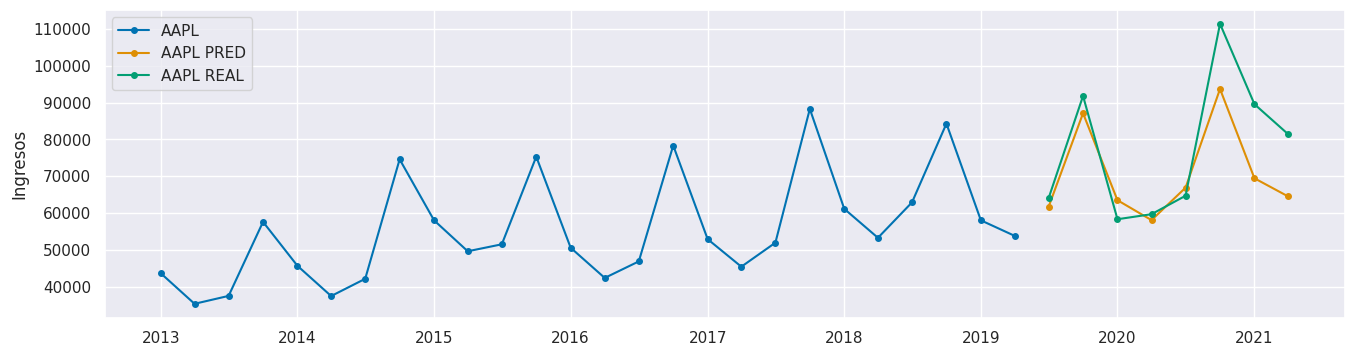

In [36]:
plot_series(np.exp(y_log_train["2013":]), np.exp(aapl_log_pred), np.exp(y_log_test), labels=["AAPL", "AAPL PRED", "AAPL REAL"])
plt.show()

In [37]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(aapl_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 11550.47


In [38]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(aapl_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 10.36%


## Comparación entre modelos ETS y ARIMA

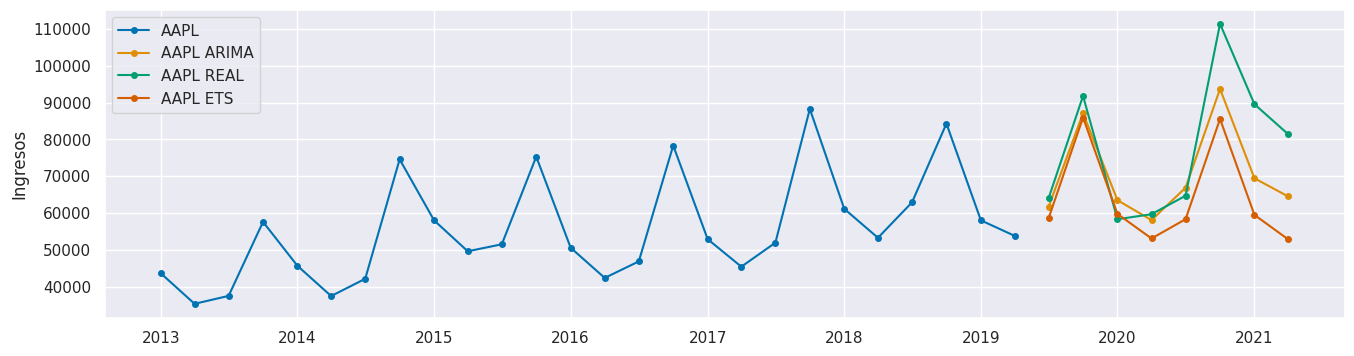

In [39]:
plot_series(np.exp(y_log_train["2013":]), np.exp(aapl_log_pred), np.exp(y_log_test), aapl_pred, labels=["AAPL", "AAPL ARIMA", "AAPL REAL", 'AAPL ETS'])
plt.show()

##### Graficamente ya podemos notar una leve mejor estimación mediante el modelo ARIMA

#### Comparación entre métricas de error:

1- RMSE (Error dependiente de la escala)

In [40]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 17825.45
El modelo ARIMA genera un RMSE de: 11550.47


Mediante esta métrica, reforzamos lo analizado graficamente.

2- MAPE (Error porcentual)

In [41]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 16.27%
El modelo ARIMA genera un MAPE de 10.36%


#### Esta métrica nos confirma que el mejor modelo para este caso es el ARIMA, ya que siempre buscamos minimizar el error.

## Análisis del efecto COVID

#### Para tener una medida del efecto del COVID sobre los ingresos de Apple, realizaremos una comparación entre los valores predichos en nuestro modelo y los valores reales para el período 2020. Ya que nuestro modelo ha sido entrenado con datos que no tienen en cuenta este efecto externo.

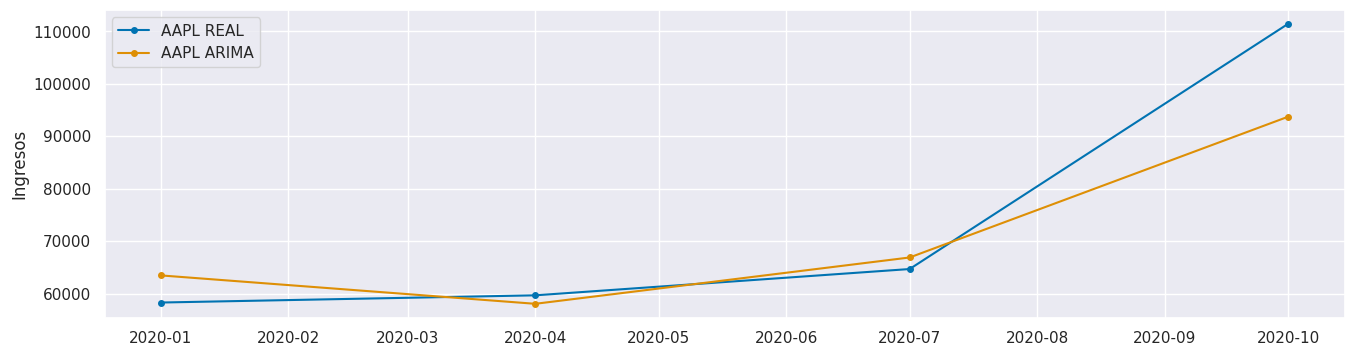

In [42]:
plot_series(np.exp(y_log_test["2020"]), np.exp(aapl_log_pred["2020"]), labels=["AAPL REAL", "AAPL ARIMA"])
plt.show()

Para cuantificar las diferencias, obtendremos la suma acumulada de las diferencias entre ambas series

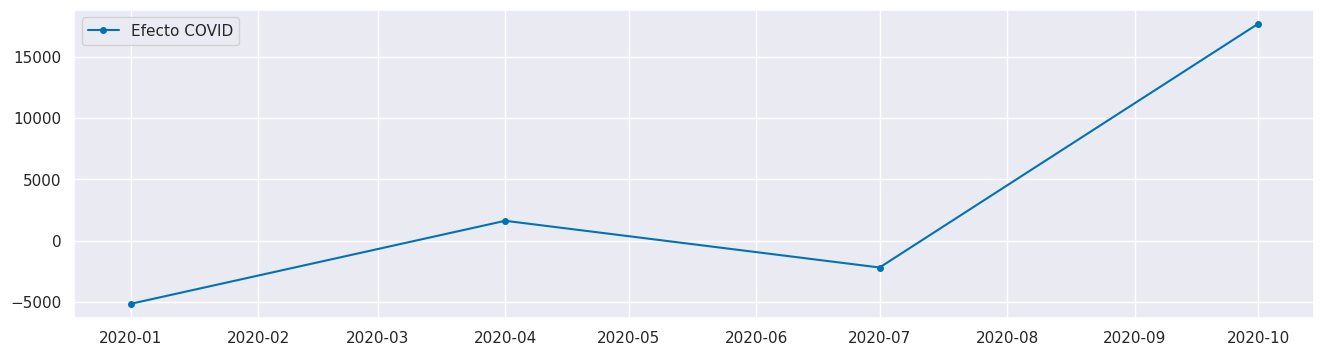

In [43]:
efecto_covid = np.exp(y_log_test["2020"]) - np.exp(aapl_log_pred["2020"])
plot_series(efecto_covid, labels=['Efecto COVID'])
plt.show()

In [44]:
print('El efecto COVID para los ingresos del año 2020 de Apple es de ${} millones de dolares en ganancias'.format(int(efecto_covid.sum())))

El efecto COVID para los ingresos del año 2020 de Apple es de $11954 millones de dolares en ganancias


# Pronósticos para 2021 y 2022

Calculo de ventas acumuladas para ambos perídos

#### Debemos realizar un cambio de frecuencia a los datos ya que trabajaremos con períodos fiscales

In [45]:
aapl_df_res.tail()

,Trimeste,Ingresos
fecha,,
2020-06-30,Q3 2020,59685.0
2020-09-30,Q4 2020,64698.0
2020-12-31,Q1 2021,111439.0
2021-03-31,Q2 2021,89584.0
2021-06-30,Q3 2021,81434.0


In [46]:
aapl_df2 = aapl_df_res
aapl_df2['Quarter'] = pd.PeriodIndex(aapl_df2.index, freq='Q-OCT')#.strftime('Q%q')
aapl_df2.set_index('Quarter', inplace=True)
aapl_fiscal_df = aapl_df2['Ingresos']
aapl_fiscal_df

,Ingresos
Quarter,
1990Q1,1493.4
1990Q2,1346.2
1990Q3,1364.8
1990Q4,1354.1
1991Q1,1675.5
...,...
2020Q3,59685.0
2020Q4,64698.0
2021Q1,111439.0


Vemos los datos del período fiscal 2020

In [47]:
aapl_fiscal_df[-7:-3]

,Ingresos
Quarter,
2020Q1,91819.0
2020Q2,58313.0
2020Q3,59685.0
2020Q4,64698.0


**Verificamos que el dato de 2020 sea le mismo que el Barclays para realizar una correcta comparación de proyecciones**

In [48]:
print('El valor de Barclays es $274515 millones para el año 2020, el dato obtenido es: ${}'.format(int(aapl_fiscal_df[-7:-3].sum())))

El valor de Barclays es $274515 millones para el año 2020, el dato obtenido es: $274515


**Debemos tomar logaritmo**

In [49]:
transformer = LogTransformer()
log_aapl_fiscal_df= transformer.fit_transform(aapl_fiscal_df)
log_aapl_fiscal_df.tail()

,Ingresos
Quarter,
2020Q3,10.996836
2020Q4,11.077486
2021Q1,11.621233
2021Q2,11.402932
2021Q3,11.307548


Entrenaremos el modelo resultante con todos los datos disponibles para luego realizar nuestras estimaciones

In [50]:
aapl_auto_model_fiscal = auto_arima(log_aapl_fiscal_df, sp=4,suppress_warnings=True)
predictor = aapl_auto_model_fiscal.fit(log_aapl_fiscal_df)

In [51]:
predictor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(3, 1, 3)   Log Likelihood                  63.150
Date:                Fri, 21 Mar 2025   AIC                           -110.300
Time:                        13:33:31   BIC                            -87.609
Sample:                    01-31-1990   HQIC                          -101.081
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1343      0.052      2.561      0.010       0.032       0.237
ar.L1         -0.9668      0.056    -17.258      0.000      -1.077      -0.857
ar.L2         -0.9827      0.044    -22.151      0.000      -1.070      -0.896
ar.L3         -0.9550      0.046    -20.753      0.000      -1.045      -0.865
ma.L1          0.7082      0.103      6.905      0.000       0.507       0.909
ma.L2          0.6489      0.130      4.990      0.000       0.394       0.904
ma.L3          0.6396      0.112      5.695      0.000       0.419       0.860
sigma2         0.0204      0.001     14.081      0.000       0.018       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               707.61
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -1.42
Prob(H) (two-sided):                  0.58   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
data_2021 = predictor.predict(1).to_frame('Sales')
sales_2021_ = np.exp(data_2021)
sales_2021_

,Sales
2021Q4,93114.150557


In [53]:
real_sales_2021 = np.exp(log_aapl_fiscal_df).to_frame('Sales')[-3:]
real_sales_2021

,Sales
Quarter,
2021Q1,111439.0
2021Q2,89584.0
2021Q3,81434.0


In [54]:
prediction_2021 = pd.concat([real_sales_2021, sales_2021_])
prediction_2021

,Sales
2021Q1,111439.000000
2021Q2,89584.000000
2021Q3,81434.000000
2021Q4,93114.150557


In [55]:
print('Es esperable que las ventas acumuladas para el año 2021 sean de ${} millones de dólares'.format(int(prediction_2021.sum())))

Es esperable que las ventas acumuladas para el año 2021 sean de $375571 millones de dólares


In [56]:

data_2022 = predictor.predict(5).to_frame('Sales')
sales_2022 = np.exp(data_2022)

prediction_2022 = sales_2022[-4:]
prediction_2022

,Sales
2022Q1,138638.530653
2022Q2,103646.024501
2022Q3,93442.266913
2022Q4,107502.808005


In [57]:
print('Es esperable que las ventas acumuladas para el año 2022 sean de ${} millones de dólares'.format(int(prediction_2022.sum())))

Es esperable que las ventas acumuladas para el año 2022 sean de $443229 millones de dólares


## Comparación entre nuestro resultado vs el informe de Barclays

Tenemos el siguiente informe que nos detalla los ingresos esperados para Apple en los períodos 2021 y 2022:

![image.png](attachment:image.png)

Calcularemos las diferencias entre las proyecciones

In [58]:
comparacion = pd.DataFrame([[274515, 368925, 378619], [int(aapl_fiscal_df[-7:-3].sum()),
                                         int(prediction_2021.sum()), int(prediction_2022.sum())]],
            columns=[2020, 2021, 2022],
            index=['Barclays', 'ARIMA'])

comparacion = comparacion.T

comparacion['Diferencia'] = comparacion.Barclays - comparacion.ARIMA

comparacion

,Barclays,ARIMA,Diferencia
2020,274515,274515,0
2021,368925,375571,-6646
2022,378619,443229,-64610


Nuestra evidencia proyecta otra realidad a la presentada por Barclays para el año 2022, si bien se estiman valores muy cercanos en 2021 (dado que solo debemos estimar un solo trimestre), es posible que la empresa esté subestimando los ingresos esperados anuales de Apple para el período 2022.

En un primer estudio, podemos decir que no son tan confiables las proyecciones de Barclays.